# CSE 252A Computer Vision I Fall 2017
## Assignment 4

## Problem 1: Install Tensorflow [2 pts]
Follow the directions on https://www.tensorflow.org/install/ to install Tensorflow on your computer.

Note: You will not need GPU support for this assignment so don't worry if you don't have one. Furthermore, installing with GPU support is often more difficult to configure so it is suggested that you install the CPU only version. However, if you have a GPU and would like to install GPU support feel free to do so at your own risk :)

Note: On windows, Tensorflow is only supported in python3, so you will need to install python3 for this assignment.

Run the following cell to verify your instalation.

In [1]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


## Problem 2: Downloading CIFAR10 [1 pts]
Download the CIFAR10 dataset (http://www.cs.toronto.edu/~kriz/cifar.html). You will need the python version: http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 

Extract the data to ./data
Once extracted run the following cell to view a few example images.

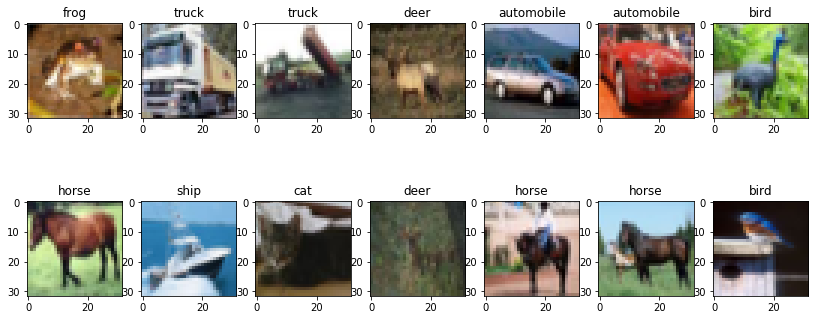

train shape: (50000, 32, 32, 3), (50000,)
test shape : (10000, 32, 32, 3), (10000,)


In [2]:
import numpy as np

# unpickles raw data files
def unpickle(file):
    import pickle
    import sys
    with open(file, 'rb') as fo:
        if sys.version_info[0] < 3:
            dict = pickle.load(fo)
        else:
           dict = pickle.load(fo, encoding='bytes') 
    return dict

# loads data from a single file
def getBatch(file):
    dict = unpickle(file)
    data = dict[b'data'].reshape(-1,3,32,32).transpose(0,2,3,1)
    labels = np.asarray(dict[b'labels'], dtype=np.int64)
    return data,labels

# loads all training and testing data
def getData(path='./data'):
    classes = [s.decode('UTF-8') for s in unpickle(path+'/batches.meta')[b'label_names']]
    
    trainData, trainLabels = [], []
    for i in range(5):
        data, labels = getBatch(path+'/data_batch_%d'%(i+1))
        trainData.append(data)
        trainLabels.append(labels)
    trainData = np.concatenate(trainData)
    trainLabels = np.concatenate(trainLabels)
    
    testData, testLabels = getBatch(path+'/test_batch')
    return classes, trainData, trainLabels, testData, testLabels

# training and testing data that will be used in the following problems
classes, trainData, trainLabels, testData, testLabels = getData()

# display some example images
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14, 6))
for i in range(14):
    plt.subplot(2,7,i+1)
    plt.imshow(trainData[i])
    plt.title(classes[trainLabels[i]])
plt.show()

print ('train shape: ' + str(trainData.shape) + ', ' + str(trainLabels.shape))
print ('test shape : ' + str(testData.shape) + ', ' + str(testLabels.shape))

Below are some helper functions that will be used in the following problems.

In [127]:
# a generator for batches of data
# yields data (batchsize, 3, 32, 32) and labels (batchsize)
# if shuffle, it will load batches in a random order
def DataBatch(data, label, batchsize, shuffle=True):
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

# tests the accuracy of a classifier
def test(testData, testLabels, classifier):
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize):
        prediction = classifier(data)
#         print (prediction)
        correct += np.sum(prediction==label)
    return correct/testData.shape[0]*100

# a sample classifier
# given an input it outputs a random class
class RandomClassifier():
    def __init__(self, classes=10):
        self.classes=classes
    def __call__(self, x):
        return np.random.randint(self.classes, size=x.shape[0])

randomClassifier = RandomClassifier()
print ('Random classifier accuracy: %f'%test(testData, testLabels, randomClassifier))

Random classifier accuracy: 9.730000


## Problem 3: Confusion Matirx [5 pts]
Here you will implement a test script that computes the confussion matrix for a classifier.
The matrix should be nxn where n is the number of classes.
Entry M[i,j] should contain the number of times an image of class i was classified as class j.
M should be normalized such that each row sums to 1.

Hint: see the function test() above for reference.

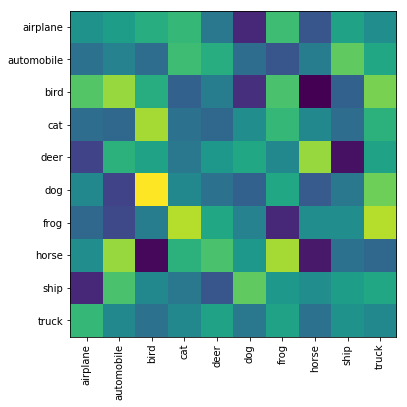

In [143]:
def confusion(testData, testLabels, classifier):
    classlabel = classifier(testData)
#     print(classlabel)
#     print(testLabels)
    M = np.zeros((classifier.classes, classifier.classes))
    for idx, i in enumerate(testLabels):
        M[i, classlabel[idx]] = M[i, classlabel[idx]] + 1
    M = M/np.sum(M, axis=1)
    return M


def VisualizeConfussion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)#, vmin=0, vmax=1)
    plt.xticks(np.arange(len(classes)), classes, rotation='vertical')
    plt.yticks(np.arange(len(classes)), classes)
    plt.show()

# print(np.shape(randomClassifier(testData)))
# print(randomClassifier.classes)
# print(np.unique(testLabels).shape)
M = confusion(testData, testLabels, randomClassifier)
VisualizeConfussion(M)

In [112]:
# a=np.array([[1,2,3],[4,5,6]])
# print(np.sum(a, axis=0))
# print(a.sum())

v = trainData[0:2]
print(v.ravel())
print(type(extractfeature(v)))

[ 59  62  63 ..., 143 133 144]
<class 'numpy.ndarray'>


## Problem 4: K-Nearest Neighbors (KNN) [5 pts]
Here you will implemnet a simple knn classifer. The distance metric is euclidian in pixel space. k refers to the number of neighbors involved in voting on the class.

Hint: you may want to use: sklearn.neighbors.KNeighborsClassifier

In [64]:
def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [144]:
def extractfeature(img):
    # vectorize image
    num, row, col, rgb = np.shape(img)
    # convert to grayscale
    new_img = img.reshape(num, row*col*rgb)
    return new_img

In [145]:
from sklearn.neighbors import KNeighborsClassifier

class KNNClassifer():
    def __init__(self, k=3, classes=10):
        # k is the number of neighbors involved in voting
        self.k = k
        self.classes = classes
        
    def train(self, trainData, trainLabels): 
        self.knn = KNeighborsClassifier(n_neighbors=self.k)
        self.knn.fit(extractfeature(trainData), trainLabels)
        
    def __call__(self, x):
        # this method should take a batch of images (batchsize, 32, 32, 3) and return a batch of prediction (batchsize)
        # predictions should be int64 values in the range [0,9] corrisponding to the class that the image belongs to
        return self.knn.predict(extractfeature(x))


In [146]:
# test your classifier with only the first 100 training examples (use this while debugging)
# note you should get around 10-20% accuracy
knnClassiferX = KNNClassifer()
knnClassiferX.train(trainData[:100], trainLabels[:100])
print ('KNN classifier accuracy: %f'%test(testData, testLabels, knnClassiferX))
# M = confusion(testData[:100], testLabels[:100], knnClassiferX)
# VisualizeConfussion(M)

KNN classifier accuracy: 16.600000


In [147]:
# test your classifier with all the training examples (This may take a while)
# note you should get around 30% accuracy
knnClassifer = KNNClassifer()
knnClassifer.train(trainData, trainLabels)
print ('KNN classifier accuracy: %f'%test(testData, testLabels, knnClassifer))

KNN classifier accuracy: 33.030000


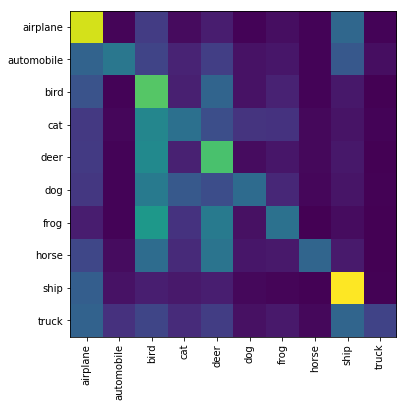

In [148]:
# display confusion matrix for your KNN classifier with all the training examples
M = confusion(testData, testLabels, knnClassifer)
VisualizeConfussion(M)

## Problem 5: Principal Component Analysis (PCA) K-Nearest Neighbors (KNN) [5 pts]
Here you will implemnet a simple knn classifer in PCA space.
You should implement PCA yourself using svd (you may not use sklearn.decomposition.PCA
or any other package that directly implements PCA transofrmations

Hint: Don't forget to apply the same normalization at test time.

Note: you should get similar accuracy to above, but it should run faster.

In [149]:
from sklearn.decomposition import PCA
# from scipy.sparse.linalg import svds, eigs
class PCAKNNClassifer():
    def __init__(self, components=25, k=3, classes=10):
        self.k = k
        self.components = components
        self.classes = classes

        
    def train(self, trainData, trainLabels):
        # each row is one dataset 
        # m pixels and n images
        # A is mxn
        A = extractfeature(trainData).T
        m,n = np.shape(A)
        self.mean = np.mean(A, 1).reshape(m, 1)
#         print('A', np.shape(A))
#         print('mean', np.shape(self.mean))
        
        # normalize feature
        A = A - self.mean
        C = A.dot(A.T)
#         print('C', np.shape(C))
        w, v = np.linalg.eigh(C)
        self.proj = v[:, np.argsort(w)[::-1][:self.components]]
        
#         print('proj', np.shape(self.proj))
        smalldata = A.T.dot(self.proj).T
#         print('smalldata', np.shape(smalldata))
#         print('label', np.shape(trainLabels))
        
        '''perform knn'''
        self.knn = KNeighborsClassifier(n_neighbors=self.k)
        # input is nxm n is number of dataset
        self.knn.fit(smalldata.T, trainLabels)
        
        
    def __call__(self, x):
        # normalize testdata
        B = extractfeature(x).T
        B = B - self.mean
        smalltest = B.T.dot(self.proj).T
        return self.knn.predict(smalltest.T)


        
    
# test your classifier with only the first 100 training examples (use this while debugging)
pcaknnClassiferX = PCAKNNClassifer()
pcaknnClassiferX.train(trainData[:100], trainLabels[:100])
print ('PCA-KNN classifier accuracy: %f'%test(testData, testLabels, pcaknnClassiferX))

PCA-KNN classifier accuracy: 16.380000


In [150]:
# a=np.array([[1,23,4], [5,6,6], [2,9,1], [5,2,6]])
# print(np.mean(a, 1))
# # print(np.cov(a))
# # print(np.shape(extractfeature(trainData[:100])))
# print(a-np.mean(a, 1).reshape(4,1))

KNN classifier accuracy: 37.890000


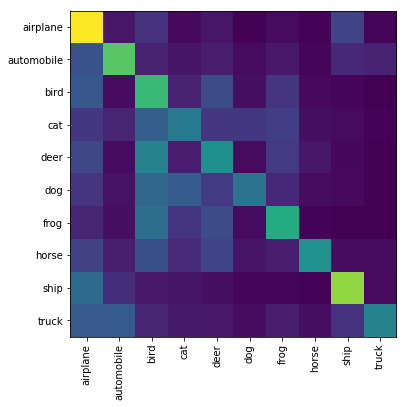

In [151]:
# test your classifier with all the training examples (This may take a few minutes)
pcaknnClassifer = PCAKNNClassifer()
pcaknnClassifer.train(trainData, trainLabels)
print ('KNN classifier accuracy: %f'%test(testData, testLabels, pcaknnClassifer))

# display the confusion matrix
M = confusion(testData, testLabels, pcaknnClassifer)
VisualizeConfussion(M)

## Deep learning
Below is some helper code to train your deep networks

Hint: see https://www.tensorflow.org/get_started/mnist/pros or https://www.tensorflow.org/get_started/mnist/beginners for reference

testing epoch:1 accuracy: 25.090000
testing epoch:2 accuracy: 26.720000
testing epoch:3 accuracy: 28.930000
testing epoch:4 accuracy: 27.060000
testing epoch:5 accuracy: 25.620000
testing epoch:6 accuracy: 24.270000
testing epoch:7 accuracy: 27.460000
testing epoch:8 accuracy: 21.230000
testing epoch:9 accuracy: 26.640000
testing epoch:10 accuracy: 26.140000
testing epoch:11 accuracy: 28.210000
testing epoch:12 accuracy: 23.340000
testing epoch:13 accuracy: 27.490000
testing epoch:14 accuracy: 25.750000
testing epoch:15 accuracy: 25.670000
testing epoch:16 accuracy: 26.720000
testing epoch:17 accuracy: 27.170000
testing epoch:18 accuracy: 27.580000
testing epoch:19 accuracy: 26.870000
testing epoch:20 accuracy: 29.830000


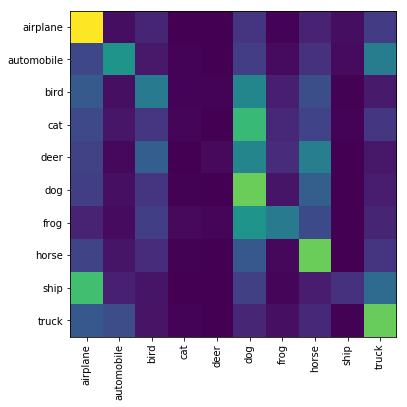

In [100]:
# base class for your Tensorflow networks. It implements the training loop (train) and prediction(__call__)  for you.
# You will need to implement the __init__ function to define the networks structures in the following problems
class TFClassifier():
    def __init__(self):
        pass
    
    def train(self, trainData, trainLabels, epochs=1, batchsize=50):
        self.prediction = tf.argmax(self.y,1)
        self.cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y_, logits=self.y))
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
        self.correct_prediction = tf.equal(self.prediction, self.y_)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
        self.sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for i, (data,label) in enumerate(DataBatch(trainData, trainLabels, batchsize, shuffle=True)):
                _, acc = self.sess.run([self.train_step, self.accuracy], feed_dict={self.x: data, self.y_: label})
                #if i%100==99:
                #    print ('%d/%d %d %f'%(epoch, epochs, i, acc))
                    
            print ('testing epoch:%d accuracy: %f'%(epoch+1, test(testData, testLabels, self)))
        
    def __call__(self, x):
        return self.sess.run(self.prediction, feed_dict={self.x: x})

# helper function to get weight variable
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

# helper function to get bias variable
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# example linear classifier
class LinearClassifer(TFClassifier):
    def __init__(self, classes=10):
        self.classes = classes
        self.sess = tf.Session()

        self.x = tf.placeholder(tf.float32, shape=[None,32,32,3]) # input batch of images
        self.y_ = tf.placeholder(tf.int64, shape=[None]) # input labels

        # model variables
        self.W = weight_variable([32*32*3,classes])
        self.b = bias_variable([classes])

        # linear operation
        self.y = tf.matmul(tf.reshape(self.x,(-1,32*32*3)),self.W) + self.b
        
# test the example linear classifier (note you should get around 20-30% accuracy)
linearClassifer = LinearClassifer()
linearClassifer.train(trainData, trainLabels, epochs=20)

# display confusion matrix
M = confusion(testData, testLabels, linearClassifer)
VisualizeConfussion(M)

## Problem 6: Multi Layer Perceptron (MLP) [5 pts]
Here you will implement an MLP. The MLP shoud consist of 3 linear layers (matrix multiplcation and bias offset) that map to the following feature dimensions:

32x32x3 -> hidden

hidden -> hidden

hidden -> classes

The first two linear layers should be followed with a ReLU nonlinearity. The final layer should not have a nonlinearity applied as we desire the raw logits output (see: the documentation for tf.nn.sparse_softmax_cross_entropy_with_logits used in the training)

The final output of the computation graph should be stored in self.y as that will be used in the training.

Hint: see the example linear classifier

Note: you should get around 50% accuracy

testing epoch:1 accuracy: 35.350000
testing epoch:2 accuracy: 42.190000
testing epoch:3 accuracy: 41.930000
testing epoch:4 accuracy: 46.500000
testing epoch:5 accuracy: 46.370000
testing epoch:6 accuracy: 46.810000
testing epoch:7 accuracy: 46.970000
testing epoch:8 accuracy: 47.400000
testing epoch:9 accuracy: 48.680000
testing epoch:10 accuracy: 47.080000
testing epoch:11 accuracy: 47.350000
testing epoch:12 accuracy: 49.940000
testing epoch:13 accuracy: 49.370000
testing epoch:14 accuracy: 49.110000
testing epoch:15 accuracy: 50.050000
testing epoch:16 accuracy: 48.670000
testing epoch:17 accuracy: 49.940000
testing epoch:18 accuracy: 49.690000
testing epoch:19 accuracy: 50.950000
testing epoch:20 accuracy: 49.210000


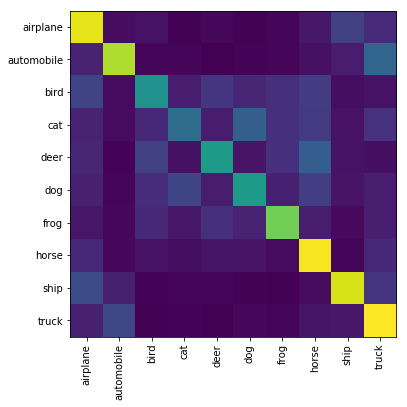

In [161]:
class MLPClassifer(TFClassifier):
    def __init__(self, classes=10, hidden=100):
        self.sess = tf.Session()
        self.classes = classes
        self.hidden = hidden

        self.x = tf.placeholder(tf.float32, shape=[None,32,32,3]) # input batch of images
        self.y_ = tf.placeholder(tf.int64, shape=[None]) # input labels

        # model variables
        self.W = weight_variable([32*32*3,classes])
        self.b = bias_variable([classes])
        
        # init
#         sess.run(tf.global_variables_initializer())
        
        # linear operation
#         self.y = tf.nn.softmax(tf.matmul(tf.reshape(self.x,(-1,32*32*3)),self.W) + self.b)
        
        # reshape traindata
        self.x_image = tf.reshape(self.x, [-1, 32*32*3])

        # first layer
        self.W_conv1 = weight_variable([32*32*3, self.hidden])
        self.b_conv1 = bias_variable([self.hidden])
        
        self.h_conv1 = tf.nn.relu(tf.matmul(self.x_image, self.W_conv1) + self.b_conv1)
#         h_pool1 = max_pool_2x2(h_conv1)
        
        # second layer
        self.W_conv2 = weight_variable([self.hidden, self.hidden])
        self.b_conv2 = bias_variable([self.hidden])

        self.h_conv2 = tf.nn.relu(tf.matmul(self.h_conv1, self.W_conv2) + self.b_conv2)
#         h_pool2 = max_pool_2x2(h_conv2)
        
        #
        self.W_conv3 = weight_variable([self.hidden, self.classes])
        self.y = tf.matmul(self.h_conv2, self.W_conv3)
        # third layer
#         self.prediction = tf.argmax(self.h_pool2, 1)
#         self.cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y_, logits=h_pool2))
#         self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
#         self.correct_prediction = tf.equal(self.prediction, self.y_)
#         self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
#         self.sess.run(tf.global_variables_initializer())
        
#         for epoch in range(epochs):
#             for i, (data,label) in enumerate(DataBatch(trainData, trainLabels, batchsize, shuffle=True)):
#                 _, acc = self.sess.run([self.train_step, self.accuracy], feed_dict={self.x: data, self.y_: label})
#                 #if i%100==99:
                #    print ('%d/%d %d %f'%(epoch, epochs, i, acc))
                    
#         print ('testing epoch:%d accuracy: %f'%(epoch+1, test(testData, testLabels, self)))
        
#     def __call__(self, x):
#         return self.sess.run(self.prediction, feed_dict={self.x: x})

        

# test your MLP classifier (note you should get around 50% accuracy)
mlpClassifer = MLPClassifer()
mlpClassifer.train(trainData, trainLabels, epochs=20)

# display confusion matrix
M = confusion(testData, testLabels, mlpClassifer)
VisualizeConfussion(M)

## Problem 7: Convolutional Neural Netork (CNN) [7 pts]
Here you will implement a CNN with the following architecture:

ReLU( Conv(kernel_size=4x4 stride=2, output_features=n) )

ReLU( Conv(kernel_size=4x4 stride=2, output_features=n*2) )

ReLU( Conv(kernel_size=4x4 stride=2, output_features=n*4) )

Linear(output_features=classes)

testing epoch:1 accuracy: 43.530000
testing epoch:2 accuracy: 51.550000
testing epoch:3 accuracy: 53.910000
testing epoch:4 accuracy: 56.160000
testing epoch:5 accuracy: 57.970000
testing epoch:6 accuracy: 60.220000
testing epoch:7 accuracy: 61.040000
testing epoch:8 accuracy: 63.050000
testing epoch:9 accuracy: 61.620000
testing epoch:10 accuracy: 64.100000
testing epoch:11 accuracy: 64.990000
testing epoch:12 accuracy: 64.510000
testing epoch:13 accuracy: 65.690000
testing epoch:14 accuracy: 66.300000
testing epoch:15 accuracy: 66.470000
testing epoch:16 accuracy: 66.120000
testing epoch:17 accuracy: 66.610000
testing epoch:18 accuracy: 66.890000
testing epoch:19 accuracy: 66.850000
testing epoch:20 accuracy: 67.400000


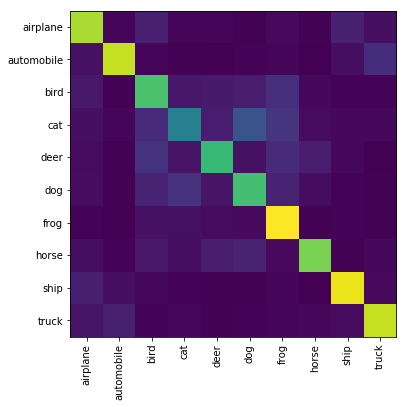

In [181]:
def conv2d(x, W, stride=2):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

class CNNClassifer(TFClassifier):
    def __init__(self, classes=10, n=16):
        self.sess = tf.Session()

        self.x = tf.placeholder(tf.float32, shape=[None,32,32,3]) # input batch of images
        self.y_ = tf.placeholder(tf.int64, shape=[None]) # input labels

        # model variables
        self.W = weight_variable([32*32*3, classes])
        self.b = bias_variable([classes])
        
        self.classes = classes
        self.n = n
        
        # reshape traindata
        self.x_image = tf.reshape(self.x, [-1, 32, 32, 3])

        # first layer
        self.W_conv1 = weight_variable([4, 4, 3, self.n])
        self.b_conv1 = bias_variable([self.n])
        
        self.h_conv1 = tf.nn.relu(conv2d(self.x_image, self.W_conv1) + self.b_conv1)
        
        # second layer
        self.W_conv2 = weight_variable([4, 4, self.n, self.n * 2])
        self.b_conv2 = bias_variable([self.n * 2])

        self.h_conv2 = tf.nn.relu(conv2d(self.h_conv1, self.W_conv2) + self.b_conv2)
        
        # third layer
        self.W_conv3 = weight_variable([4, 4, self.n * 2, self.n * 4])
        self.b_conv3 = bias_variable([self.n * 4])

        self.h_conv3 = tf.nn.relu(conv2d(self.h_conv2, self.W_conv3) + self.b_conv3)
                
        # forth layer
        self.h_conv3 = tf.reshape(self.h_conv3, [-1, 4 * 4 * self.n * 4])
        self.W_conv4 = weight_variable([4 * 4 * self.n * 4, self.classes])
        self.y = tf.matmul(self.h_conv3, self.W_conv4)


# test your CNN classifier (note you should get around 65% accuracy)
cnnClassifer = CNNClassifer()
cnnClassifer.train(trainData, trainLabels, epochs=20)

# display confusion matrix
M = confusion(testData, testLabels, cnnClassifer)
VisualizeConfussion(M)

## Further reference
To see how state of the art deep networks do on this dataset see: https://github.com/tensorflow/models/tree/master/research/resnet